In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np 
from openbb import obb
from datetime import date
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from datetime import date
import warnings
warnings.filterwarnings('ignore')

obb.user.preferences.output_type = 'dataframe'

In [36]:
tickers = [
    "AAPL", # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "AMZN",  # Amazon.com Inc.
    "META",  # Meta Platforms Inc.
    "NVDA",  # NVIDIA Corporation
    "TSLA",  # Tesla Inc.
    "JPM",   # JPMorgan Chase & Co.
    "V",     # Visa Inc.
    "AMD", # AMD 
    "KO", # Coca Cola
    "SBUX", #Starbucks
    "PEP", # Pepsi
    "GE", # General Electric
    "GM", # General Motors
    "NFLX", # Netflix
    "RBLX", # Roblox
    "SONY", # Sony
    "WMT", # Walmart
    "IBM", # IBM
    "TGT", # target
    "COF" ,# Capital One,
    "PLTR", # Palantir,
    "MELI", # MercadoLibre
    "ROAD", #Construction
    "QUBT", # Quantum Computing
    "SHOP", # Shopify
    "ADBE" ,# Adobe
    "BRK-B",# berkshire hathaway
    "OKLO", # Oklo Inc
    "SMR", # Nuscale Power Corp
    "HOOD", # Robinhood 
    "GIL", # gildan
    "SPY" # SP 500  

]
end = pd.Timestamp.today().normalize()


In [37]:
def get_historical_Data(tickers):
    end_date = date.today().isoformat() 
    names = list()
    mapp = {}
    for i in tickers:
        data = pd.DataFrame(yf.download(i, end=end_date, progress=False))
        columns = data.columns
        
        data.columns = [i for i,stock in columns]
        mapp[i] = data
    

    return mapp

portolio = ['AAPL', 'NVDA', 'SBUX', 'GE','SPY']

def combined_portfolio_data(stock_portfolio):
    data = yf.download(stock_portfolio, end = end).Close

    return data.dropna()

In [38]:
porfolio_data = combined_portfolio_data(portolio) 

total_porfolio_returns = porfolio_data.pct_change().sum(axis = 1)

[*********************100%***********************]  5 of 5 completed


In [5]:
start = str(porfolio_data.index[0]).split(" ")[0]

In [6]:
total_porfolio_returns.name = 'porfolio_returns'


# market - risk free rate, small minus big stocks, high minus low, risk free
fama_french = web.DataReader('F-F_Research_Data_Factors_daily',
                             'famafrench',
                             start = start,
                             end = end)[0]

In [7]:
together = pd.concat([fama_french, total_porfolio_returns], axis = 1).dropna()

excess_returns = together.porfolio_returns - together.RF
excess_returns.name = "Excess Returns"

excess_returns

together

,Mkt-RF,SMB,HML,RF,porfolio_returns
Date,,,,,
1999-01-22,-0.66,0.41,0.15,0.02,0.000000
1999-01-25,0.67,-0.95,0.09,0.02,0.157914
1999-01-26,1.39,-0.25,-1.12,0.02,0.000304
1999-01-27,-0.74,0.10,-0.64,0.02,-0.068234
1999-01-28,1.63,-1.07,-0.50,0.02,0.052719
...,...,...,...,...,...
2025-09-24,-0.34,-0.36,0.99,0.02,-0.053707
2025-09-25,-0.58,-0.77,0.55,0.02,0.001917
2025-09-26,0.60,0.28,0.45,0.02,-0.009598


In [8]:
x  = together[['SMB', 'HML']]
x = sm.add_constant(x)

model = sm.OLS(excess_returns, x).fit()
hedge_weights = -model.params[1:]

-model.params[1:] * 100

SMB   -1.700653
HML    0.859028
dtype: float64

In [13]:
hedge_portfolio = (together[['SMB', 'HML']] @ hedge_weights).dropna()

hedge_portfolio_returns = total_porfolio_returns.loc[hedge_portfolio.index] + hedge_portfolio

hedge = pd.DataFrame({
    'unhedged_returns' : total_porfolio_returns.loc[hedge_portfolio_returns.index], 
    'hedged_returns' : hedge_portfolio_returns})

import math
sharpe_ratio = pd.DataFrame(hedge.mean() / hedge.std() * math.sqrt(252), columns = ['Sharpe Ratio of Full Porfolio'])

sharpe_ratio

,Sharpe Ratio of Full Porfolio
unhedged_returns,0.900253
hedged_returns,0.903015


In [14]:
data = get_historical_Data(tickers)


In [15]:
apple = data['AAPL']


In [17]:
spy = data['SPY']

In [18]:
# stock_info #
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=10)

# look to webscrape this metric from fred 
# https://fred.stlouisfed.org/series/DGS10
risk_free = .00411
adjustment_factor = 0.0


sharpe_dictionary = {}
sortino_ratio_dictionary = {}
betas = {}
alphas = {}

# alpha is defined as


for stock, stock_data in data.items():
    stock_data['returns'] = stock_data['Close'].pct_change()
    stock_data['log_returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna()

    
    start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)
    # needed for declaring a beta
    # spy_returns =  stock_data['SPY']['log_returns']
    # spy_returns = spy_returns[spy_returns.index > start_beta]



    
    idx = stock_data.index.slice_indexer(start=start, end=end)
    last_ten_years_data = stock_data.iloc[idx]
    YoY_cagr_ten = (last_ten_years_data['Close'].iloc[-1] / last_ten_years_data['Close'].iloc[0]) ** (1/10) - 1 
    sigma =  last_ten_years_data['returns'].std(ddof = 0) * np.sqrt(252)
    sharpe_ratio_ten_year = (YoY_cagr_ten - risk_free)  / (sigma)
    sharpe_dictionary[stock] = {"Sharpe Ratio Ten Year" : sharpe_ratio_ten_year}
    
    # sortino ratio
    returns_risk_adj = np.asanyarray(stock_data['returns'].dropna() - adjustment_factor)
    average_annual_return = returns_risk_adj.mean() * 252
    downside_difference = np.clip(returns_risk_adj, np.NINF, 0)
    np.square(downside_difference, out = downside_difference)
    annualized_downside_deviation = np.sqrt(downside_difference.mean()) * np.sqrt(252)
    sortino_ratio = average_annual_return / annualized_downside_deviation
    sortino_ratio_dictionary[stock] = {"Sortino Ratio" : sortino_ratio}


    # beta for each stock
    start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

    if stock == 'SPY':
        continue
    start = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

    stock_return = stock_data['log_returns']

    
    starting_point_returns = stock_return[stock_return.index > start]

    if len(starting_point_returns.index) != len(spy_returns.index):
        betas[stock] = np.nan
        continue
        
    co_variance = np.cov(starting_point_returns, spy_returns)[0,1]
    
    
    beta = co_variance / np.var(spy_returns)
    betas[stock] = {"Beta" : beta} 

    ## alpha comparative with betas

    five_year_return = starting_point_returns[0] / starting_point_returns[-1]  

    five_year_market_return = spy_returns[0] / spy_returns[-1]

    alpha = five_year_return - (risk_free + (beta * (five_year_market_return -  risk_free)))

    alphas[stock] = {'Alphas': alpha}



df_sharpe = pd.DataFrame(sharpe_dictionary)
df_sortino = pd.DataFrame(sortino_ratio_dictionary)
df_beta = pd.DataFrame(betas)
df_alpha = pd.DataFrame(alphas)



df_final = pd.concat([df_sharpe, df_sortino, df_beta,df_alpha], axis = 0)

NameError: name 'spy_returns' is not defined

In [ ]:
df_final

$$
\text{Sharpe Ratio} = \frac{\mathbb{E}\!\left[R_p - R_f\right]}{\sigma\!\left(R_p\right)}
$$

In [19]:
def sharpe_ratio(returns, adjustment_factor=0.0):
    returns_risk_adj = returns - adjustment_factor
    return (
        returns_risk_adj.mean() / returns_risk_adj.std()
    ) * np.sqrt(252)

<Axes: xlabel='Date'>

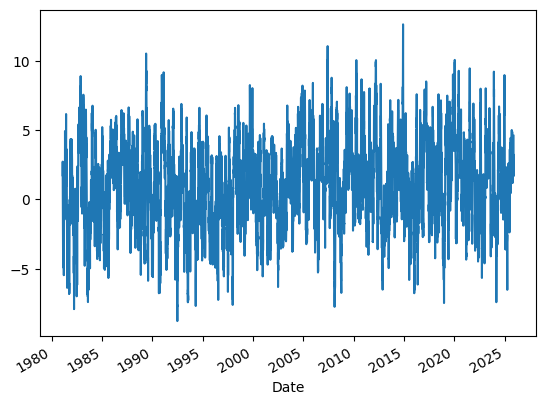

In [20]:
apples_sharpe = sharpe_ratio(apple)

apples_sharpe

test = apple['Close'].pct_change().rolling(30).apply(sharpe_ratio)


test.plot()

## How would I calculate Beta

$$
\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$


In [21]:
end = pd.Timestamp.today().normalize()
start = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

apple_returns = apple['log_returns']
spy_returns =  data['SPY']['log_returns']

apple_returns = apple_returns[apple_returns.index > start]
spy_returns = spy_returns[spy_returns.index > start]

co_variance = np.cov(apple_returns, spy_returns)[0,1]


beta = co_variance / np.var(spy_returns)
beta

KeyError: 'log_returns'

In [ ]:
apple_returns = apple_returns[apple_returns.index > start]
# spy_returns = spy_returns[spy_returns.index > start]


In [ ]:
apple_returns
apple_returns

In [ ]:
np.log(apple['Close'] / apple['Close'].shift(1)).dropna()

In [65]:
# def alpha_beta(sales):

spy = get_historical_Data(['SPY'])['SPY']
start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

spy['returns'] =  spy['Close'].pct_change()
spy['log_returns'] =  np.log(spy['Close'] / spy['Close'].shift(1))
# spy = spy.dropna()

# # spy_log_returns
# spy_ = spy[spy_log_returns.index > start_beta]['log_returns']

# spy_returns

spy

apple

spy
spy = spy['log_returns']
# apple = apple['log_returns']
apple= data['AAPL']
apple_log_returns = apple['log_returns']
spy

apple = pd.DataFrame(apple_log_returns)
spy =pd.DataFrame(spy)

together  = pd.concat([apple, spy], axis = 1)

together.dropna()

,log_returns,log_returns
Date,,
1993-02-01,0.028988,0.007087
1993-02-02,-0.016462,0.002116
1993-02-03,-0.004158,0.010515
1993-02-04,-0.008367,0.004176
1993-02-05,-0.038548,-0.000695
...,...,...
2025-11-17,-0.018338,-0.009360
2025-11-18,-0.000075,-0.008433
2025-11-19,0.004179,0.003856


In [88]:
import requests

url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=all"

# Read tables from the page
tables = pd.read_html(url)

# Usually the first table is the main data
df = tables[0]

# Preview
print(df.head())

         Date  20 YR  30 YR  Extrapolation Factor  6 WEEKS BANK DISCOUNT  \
0  01/02/1990    NaN    NaN                   NaN                    NaN   
1  01/03/1990    NaN    NaN                   NaN                    NaN   
2  01/04/1990    NaN    NaN                   NaN                    NaN   
3  01/05/1990    NaN    NaN                   NaN                    NaN   
4  01/08/1990    NaN    NaN                   NaN                    NaN   

   COUPON EQUIVALENT  8 WEEKS BANK DISCOUNT  COUPON EQUIVALENT.1  \
0                NaN                    NaN                  NaN   
1                NaN                    NaN                  NaN   
2                NaN                    NaN                  NaN   
3                NaN                    NaN                  NaN   
4                NaN                    NaN                  NaN   

   17 WEEKS BANK DISCOUNT  COUPON EQUIVALENT.2  ...  4 Mo  6 Mo  1 Yr  2 Yr  \
0                     NaN                  NaN  ...   N

In [102]:
df.columns
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

KeyError: 'Date'

In [104]:
df = df.drop(columns=[col for col in df.columns if col != '5 Yr'])
df

,5 Yr
Date,
1990-01-02,7.87
1990-01-03,7.92
1990-01-04,7.91
1990-01-05,7.92
1990-01-08,7.92
...,...
1991-03-08,7.77
1991-03-11,7.71
1991-03-12,7.74
